# Preprocesado de datos

## Imports

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('precision', 3)

## Carga de datos

En el dataset, los datos no definidos (missing) estan especificados con un simbolo de interrogacion.

In [58]:
original_data = pd.read_csv('dataset/automobile.csv', na_values=['?'])
data = pd.read_csv('dataset/automobile.csv', na_values=['?'])

### Categorias a OneHotEncoding

Dado que contamos con categorias que no cuentan ni con relacion de orden, ni magnitud, para no confundir a los modelos creados, hemos decidido convertirlas a One Hot Encoding.


In [59]:
data = pd.get_dummies(data,
        columns=['make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels',
                 'engine_location', 'engine_type', 'fuel_system'],
        prefix=['make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels',
                'engine_location', 'engine_type', 'fuel_system'])

### Cambiamos las categorias numericas por el numero correspondiente:

In [60]:
str_to_num = {"num_of_doors"     : {"two": int(2), "four": 4},
              "num_of_cylinders" : {"two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "eight": 8, "twelve": 12 }}

data.replace(str_to_num, inplace=True)

## Valores faltantes (Missing Values)

### Busqueda de Missings
Nuestro dataset ya especicaba los valores missing con un '?'. Podemos verlo en la informacion de nuestro dataframe:

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               205 non-null    int64  
 1   normalized_losses       164 non-null    float64
 2   num_of_doors            203 non-null    float64
 3   wheel_base              205 non-null    float64
 4   length                  205 non-null    float64
 5   width                   205 non-null    float64
 6   height                  205 non-null    float64
 7   curb_weight             205 non-null    int64  
 8   num_of_cylinders        205 non-null    int64  
 9   engine_size             205 non-null    int64  
 10  bore                    201 non-null    float64
 11  stroke                  201 non-null    float64
 12  compression_ratio       205 non-null    float64
 13  horsepower              203 non-null    float64
 14  peak_rpm                203 non-null    fl

A pesar de ello, creemos adecuado comprobar que no haya valores extranos, como podrian ser ceros donde no deberia, o numeros que puedan parecer un error de medicion como +-999999.

In [62]:
data.describe()

,symboling,normalized_losses,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,...,engine_type_ohcv,engine_type_rotor,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
count,205.000,164.000,203.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,...,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000
mean,0.834,122.000,3.123,98.757,174.049,65.908,53.725,2555.566,4.380,126.907,...,0.063,0.020,0.054,0.322,0.015,0.098,0.005,0.459,0.044,0.005
std,1.245,35.442,0.995,6.022,12.337,2.145,2.444,520.680,1.081,41.643,...,0.244,0.139,0.226,0.468,0.120,0.297,0.070,0.499,0.205,0.070
min,-2.000,65.000,2.000,86.600,141.100,60.300,47.800,1488.000,2.000,61.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,94.000,2.000,94.500,166.300,64.100,52.000,2145.000,4.000,97.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,115.000,4.000,97.000,173.200,65.500,54.100,2414.000,4.000,120.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2.000,150.000,4.000,102.400,183.100,66.900,55.500,2935.000,4.000,141.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
max,3.000,256.000,4.000,120.900,208.100,72.300,59.800,4066.000,12.000,326.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Vemos que tanto los minimos como los maximos de todas las variables continuas no parecen ser errores, sino datos reales.

### Tratamiento de Missings

Dependiendo que atributo sea el que contiene missing values, y que cantidad haya de estos, actuaremos de una manera u otra:

#### 'Price'
Dado que el objetivo es hacer regresion sobre el atributo 'price', creemos conveniente eliminar las 4 filas que no contienen este atributo, ya que son pocas y creemos que no merece la pena imputar valores que luego vamos a intentar predecir, ya sea para fase de training o de test.

In [63]:
data = data[~data['price'].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               201 non-null    int64  
 1   normalized_losses       164 non-null    float64
 2   num_of_doors            199 non-null    float64
 3   wheel_base              201 non-null    float64
 4   length                  201 non-null    float64
 5   width                   201 non-null    float64
 6   height                  201 non-null    float64
 7   curb_weight             201 non-null    int64  
 8   num_of_cylinders        201 non-null    int64  
 9   engine_size             201 non-null    int64  
 10  bore                    197 non-null    float64
 11  stroke                  197 non-null    float64
 12  compression_ratio       201 non-null    float64
 13  horsepower              199 non-null    float64
 14  peak_rpm                199 non-null    fl

#### Marca Renault
Nos hemos dado cuenta de que los unicos dos coches de la marca Renault, tienen missings, en 3 de sus columnas. Creemos que es adecuado eliminar estas 2 filas ya que desde nuestro punto de vista, les falta demasiada informacion y ambas conforman una marca completa. Es decir, imputar estas 3 columnas, influira directamente sobre cualquier prediccion de la marca Renault, y creemos que 2 filas son pocas y podemos tolerar eliminarlas.

In [64]:
data[data['make_renault'] == 1].info()
data = data[data['make_renault'] == 0]
data.drop(columns=['make_renault'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 130 to 131
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               2 non-null      int64  
 1   normalized_losses       0 non-null      float64
 2   num_of_doors            2 non-null      float64
 3   wheel_base              2 non-null      float64
 4   length                  2 non-null      float64
 5   width                   2 non-null      float64
 6   height                  2 non-null      float64
 7   curb_weight             2 non-null      int64  
 8   num_of_cylinders        2 non-null      int64  
 9   engine_size             2 non-null      int64  
 10  bore                    2 non-null      float64
 11  stroke                  2 non-null      float64
 12  compression_ratio       2 non-null      float64
 13  horsepower              0 non-null      float64
 14  peak_rpm                0 non-null      fl

#### Motores rotativos
El dataset cuenta con unos coches con un motor muy peculiar de la marca Mazda. Este motor, conocido como motor Wankel es de tipo rotativo , es decir, genera energia cinetica de forma rotativa directamente sin hacer uso de pistones lineales. Esto es importanto porque, al no contar con pistones, no contamos con los datos 'bore' y 'stroke' (calibre y carrera), ya que son caracteristicas propias de los pistones. Eso explica los missing values en estos datos. 

In [65]:
data.info()
data[data['engine_type_rotor'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               199 non-null    int64  
 1   normalized_losses       164 non-null    float64
 2   num_of_doors            197 non-null    float64
 3   wheel_base              199 non-null    float64
 4   length                  199 non-null    float64
 5   width                   199 non-null    float64
 6   height                  199 non-null    float64
 7   curb_weight             199 non-null    int64  
 8   num_of_cylinders        199 non-null    int64  
 9   engine_size             199 non-null    int64  
 10  bore                    195 non-null    float64
 11  stroke                  195 non-null    float64
 12  compression_ratio       199 non-null    float64
 13  horsepower              199 non-null    float64
 14  peak_rpm                199 non-null    fl

Podemos ver que todos los missings de 'bore' y de 'stroke' son de los motores rotativos. Procedemos a ponerlos todos a 0 ya que consideramos que el recorrido y el calibre es nulo:

In [66]:
data['bore'].fillna(0, inplace=True)
data['stroke'].fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               199 non-null    int64  
 1   normalized_losses       164 non-null    float64
 2   num_of_doors            197 non-null    float64
 3   wheel_base              199 non-null    float64
 4   length                  199 non-null    float64
 5   width                   199 non-null    float64
 6   height                  199 non-null    float64
 7   curb_weight             199 non-null    int64  
 8   num_of_cylinders        199 non-null    int64  
 9   engine_size             199 non-null    int64  
 10  bore                    199 non-null    float64
 11  stroke                  199 non-null    float64
 12  compression_ratio       199 non-null    float64
 13  horsepower              199 non-null    float64
 14  peak_rpm                199 non-null    fl

#### 'Num_of_doors' missing
Utilizamos KNN para imputar el valor de los missings que faltan del atributo "num_of_doors":

In [67]:
subset_of_data = data.drop(columns=['normalized_losses', 'num_of_doors'])
data_without_missings = subset_of_data[data.num_of_doors.notna() & data.normalized_losses.notna()]

data_num_of_doors_missing = subset_of_data[data.num_of_doors.isna()]
knn_num_of_doors = KNeighborsClassifier(n_neighbors=1)
knn_num_of_doors.fit(data_without_missings, data.num_of_doors[data.num_of_doors.notna() & data.normalized_losses.notna()])

KNeighborsClassifier(n_neighbors=1)

In [68]:
# predicted_num_of_doors = knn_num_of_doors.predict(data_num_of_doors_missing)
# data.num_of_doors[data.num_of_doors.isna()] = predicted_num_of_doors
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               199 non-null    int64  
 1   normalized_losses       164 non-null    float64
 2   num_of_doors            197 non-null    float64
 3   wheel_base              199 non-null    float64
 4   length                  199 non-null    float64
 5   width                   199 non-null    float64
 6   height                  199 non-null    float64
 7   curb_weight             199 non-null    int64  
 8   num_of_cylinders        199 non-null    int64  
 9   engine_size             199 non-null    int64  
 10  bore                    199 non-null    float64
 11  stroke                  199 non-null    float64
 12  compression_ratio       199 non-null    float64
 13  horsepower              199 non-null    float64
 14  peak_rpm                199 non-null    fl

In [69]:
data_clean = data[data.num_of_doors.notna()].drop(columns=['num_of_doors', 'normalized_losses'])

doors_clean = data.num_of_doors[data.num_of_doors.notna()]

doors_missing = data[data.num_of_doors.isna()].drop(columns=['num_of_doors', 'normalized_losses'])


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(data_clean, doors_clean)
data.num_of_doors[data.num_of_doors.isna()] = knn.predict(doors_missing)

KNeighborsClassifier(n_neighbors=1)

<ipython-input-69-d4a86ff30f58>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.num_of_doors[data.num_of_doors.isna()] = knn.predict(doors_missing)


#### Imputacion de Normalized Losses 

Como tenemos muchos missings en esta columna, para no reducir tanto la varianza,
hemos decidido imputar los valores tomando valores intermedios de cada marca. Dado que los datos estan normalizados, no existen outlier (aparentemente) y creemos conveniente utilizar la media aritmetica en vez de la moda. 

Para aquellas marcas (alfa_romeo), que no cuentan con ningun valor de este atributo, hemos decidido utilizar la media global de la columna.

In [71]:
makes = ['make_alfa_romero', 'make_audi', 'make_bmw', 'make_chevrolet', 
         'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 
         'make_mercedes_benz', 'make_mercury', 'make_mitsubishi', 'make_nissan',
         'make_peugot', 'make_plymouth', 'make_porsche', 'make_saab',
         'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo']

# replace nan by make mean
for make in makes:
  aux = data.normalized_losses[data[make] == 1]
  make_mean = aux[aux.notna()].values.mean()
  data[data[make] == 1] = data[data[make] == 1].fillna(make_mean);

# as some make is completely missing, we decided to replace these by the global mean
full_mean = data.normalized_losses[data.normalized_losses.notna()].values.mean()
data.normalized_losses = data.normalized_losses.fillna(full_mean)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               199 non-null    int64  
 1   normalized_losses       199 non-null    float64
 2   num_of_doors            199 non-null    float64
 3   wheel_base              199 non-null    float64
 4   length                  199 non-null    float64
 5   width                   199 non-null    float64
 6   height                  199 non-null    float64
 7   curb_weight             199 non-null    int64  
 8   num_of_cylinders        199 non-null    int64  
 9   engine_size             199 non-null    int64  
 10  bore                    199 non-null    float64
 11  stroke                  199 non-null    float64
 12  compression_ratio       199 non-null    float64
 13  horsepower              199 non-null    float64
 14  peak_rpm                199 non-null    fl

## Estudio estadistico de los atributos

### Deshacer Dummy Variables
Para facilitar el estudio estadistico de las variables y hacer graficos de forma mas facil, reformateamos el set de datos a una version sin Dummy Variables.

In [73]:
data.columns
makes = ['make_alfa_romero', 'make_audi', 'make_bmw', 'make_chevrolet', 
         'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 
         'make_mercedes_benz', 'make_mercury', 'make_mitsubishi', 'make_nissan',
         'make_peugot', 'make_plymouth', 'make_porsche', 'make_saab',
         'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo']

drive_wheels = ['drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd']

engine_location = ['engine_location_front', 'engine_location_rear']

fuel_types = ['fuel_type_diesel', 'fuel_type_gas']

aspiration = ['aspiration_std', 'aspiration_turbo']

body_styles = ['body_style_convertible', 'body_style_hardtop',
               'body_style_hatchback', 'body_style_sedan', 'body_style_wagon',]

engine_type = ['engine_type_dohc', 'engine_type_dohcv', 'engine_type_l', 
               'engine_type_ohc', 'engine_type_ohcf', 'engine_type_ohcv',
               'engine_type_rotor']

fuel_system = ['fuel_system_1bbl', 'fuel_system_2bbl', 'fuel_system_4bbl', 
               'fuel_system_idi', 'fuel_system_mfi', 'fuel_system_mpfi',
               'fuel_system_spdi', 'fuel_system_spfi']

all_cols = makes + drive_wheels + fuel_types + aspiration + body_styles + \
           engine_location + engine_type + fuel_system

data_no_OH = data.drop(columns=all_cols)
data_no_OH['make'] = original_data.make
data_no_OH['drive_wheels'] = original_data.drive_wheels
data_no_OH['fuel_type'] = original_data.fuel_type
data_no_OH['aspiration'] = original_data.aspiration
data_no_OH['body_style'] = original_data.body_style
data_no_OH['engine_type'] = original_data.engine_type
data_no_OH['fuel_system'] = original_data.fuel_system
data_no_OH['engine_location'] = original_data.engine_location

data_no_OH.info()

Index(['symboling', 'normalized_losses', 'num_of_doors', 'wheel_base',
       'length', 'width', 'height', 'curb_weight', 'num_of_cylinders',
       'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower',
       'peak_rpm', 'city_mpg', 'highway_mpg', 'price', 'make_alfa_romero',
       'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda',
       'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes_benz',
       'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot',
       'make_plymouth', 'make_porsche', 'make_saab', 'make_subaru',
       'make_toyota', 'make_volkswagen', 'make_volvo', 'fuel_type_diesel',
       'fuel_type_gas', 'aspiration_std', 'aspiration_turbo',
       'body_style_convertible', 'body_style_hardtop', 'body_style_hatchback',
       'body_style_sedan', 'body_style_wagon', 'drive_wheels_4wd',
       'drive_wheels_fwd', 'drive_wheels_rwd', 'engine_location_front',
       'engine_location_rear', 'engine_type_dohc', 'engine_type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          199 non-null    int64  
 1   normalized_losses  199 non-null    float64
 2   num_of_doors       199 non-null    float64
 3   wheel_base         199 non-null    float64
 4   length             199 non-null    float64
 5   width              199 non-null    float64
 6   height             199 non-null    float64
 7   curb_weight        199 non-null    int64  
 8   num_of_cylinders   199 non-null    int64  
 9   engine_size        199 non-null    int64  
 10  bore               199 non-null    float64
 11  stroke             199 non-null    float64
 12  compression_ratio  199 non-null    float64
 13  horsepower         199 non-null    float64
 14  peak_rpm           199 non-null    float64
 15  city_mpg           199 non-null    int64  
 16  highway_mpg        199 non

### Atributos numericos

#### Data info

In [74]:
data_no_OH.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          199 non-null    int64  
 1   normalized_losses  199 non-null    float64
 2   num_of_doors       199 non-null    float64
 3   wheel_base         199 non-null    float64
 4   length             199 non-null    float64
 5   width              199 non-null    float64
 6   height             199 non-null    float64
 7   curb_weight        199 non-null    int64  
 8   num_of_cylinders   199 non-null    int64  
 9   engine_size        199 non-null    int64  
 10  bore               199 non-null    float64
 11  stroke             199 non-null    float64
 12  compression_ratio  199 non-null    float64
 13  horsepower         199 non-null    float64
 14  peak_rpm           199 non-null    float64
 15  city_mpg           199 non-null    int64  
 16  highway_mpg        199 non

Index(['symboling', 'normalized_losses', 'num_of_doors', 'wheel_base',
       'length', 'width', 'height', 'curb_weight', 'num_of_cylinders',
       'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower',
       'peak_rpm', 'city_mpg', 'highway_mpg', 'price', 'make_alfa_romero',
       'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda',
       'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes_benz',
       'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot',
       'make_plymouth', 'make_porsche', 'make_saab', 'make_subaru',
       'make_toyota', 'make_volkswagen', 'make_volvo', 'fuel_type_diesel',
       'fuel_type_gas', 'aspiration_std', 'aspiration_turbo',
       'body_style_convertible', 'body_style_hardtop', 'body_style_hatchback',
       'body_style_sedan', 'body_style_wagon', 'drive_wheels_4wd',
       'drive_wheels_fwd', 'drive_wheels_rwd', 'engine_location_front',
       'engine_location_rear', 'engine_type_dohc', 'engine_type

#### Correlation

In [75]:
data_no_OH.corr()

,symboling,normalized_losses,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
symboling,1.000,0.472,-0.670,-0.538,-0.366,-0.244,-0.547,-0.233,-0.118,-0.111,-0.284,-0.211,-0.182,0.076,0.281,-0.035,0.036,-0.082
normalized_losses,0.472,1.000,-0.351,-0.013,0.106,0.142,-0.336,0.200,0.196,0.223,-0.051,-0.053,-0.112,0.353,0.247,-0.322,-0.272,0.296
num_of_doors,-0.670,-0.351,1.000,0.447,0.396,0.230,0.534,0.208,0.002,0.024,0.204,0.135,0.170,-0.103,-0.233,-0.028,-0.046,0.042
wheel_base,-0.538,-0.013,0.447,1.000,0.880,0.817,0.593,0.783,0.348,0.573,0.319,0.165,0.249,0.372,-0.361,-0.473,-0.544,0.584
length,-0.366,0.106,0.396,0.880,1.000,0.857,0.495,0.882,0.442,0.685,0.355,0.116,0.161,0.580,-0.286,-0.665,-0.699,0.694
width,-0.244,0.142,0.230,0.817,0.857,1.000,0.309,0.867,0.522,0.729,0.282,0.115,0.191,0.615,-0.246,-0.633,-0.681,0.754
height,-0.547,-0.336,0.534,0.593,0.495,0.309,1.000,0.308,0.007,0.076,0.304,0.172,0.260,-0.087,-0.312,-0.051,-0.105,0.135
curb_weight,-0.233,0.200,0.208,0.783,0.882,0.867,0.308,1.000,0.605,0.849,0.356,0.130,0.156,0.758,-0.279,-0.750,-0.795,0.835
num_of_cylinders,-0.118,0.196,0.002,0.348,0.442,0.522,0.007,0.605,1.000,0.849,0.379,0.276,-0.019,0.669,-0.152,-0.441,-0.474,0.708
engine_size,-0.111,0.223,0.024,0.573,0.685,0.729,0.076,0.849,0.849,1.000,0.447,0.272,0.029,0.823,-0.257,-0.651,-0.680,0.874


#### Price


Vemos que el precio esta principalmente localizado entre 7.7K y 16.5K dolares. El boxplot revela que contamos con muchos valores que podriamos considerar Outliers.

Text(0.5, 1.0, 'Global Price')

count      199.000
mean     13243.432
std       7978.708
min       5118.000
25%       7775.000
50%      10345.000
75%      16501.500
max      45400.000
Name: price, dtype: float64

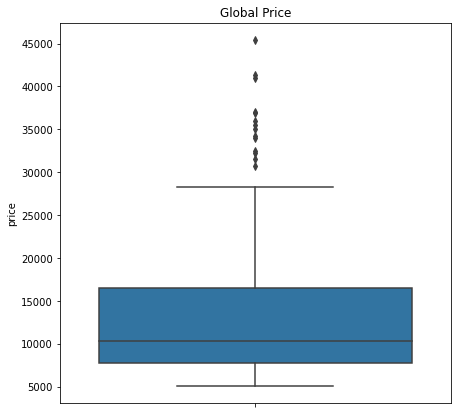

In [76]:
plt.rcParams['figure.figsize']=(7,7)
sn.boxplot(y="price", data=data_no_OH).set_title('Global Price');
data.price.describe()

Para mayor precision, visualizamos la distribucion del precio respecto a cada una de las marcas de vehiculos del dataset. Podemos ver que marcas Europeas como Jaguar, BMW o Porsche tienen precios mucho mas altos que el resto. Esto se debe principalmente a que la informacion de precios esta sesgada, por ser precios de Estados Unidos en el 1987 y por lo tanto, todo vehiculo importado de Europa siempre sera mucho mas caro que uno americano o asiatico. 

Por lo tanto, estos Outliers del boxplot anterior, son en realidad valores correctos que debido al desbalanceo entre vehiculos asiaticos, eurpeos y americanos, se detectan como minoritarios y no entran dentro del la zona somberada de azul.

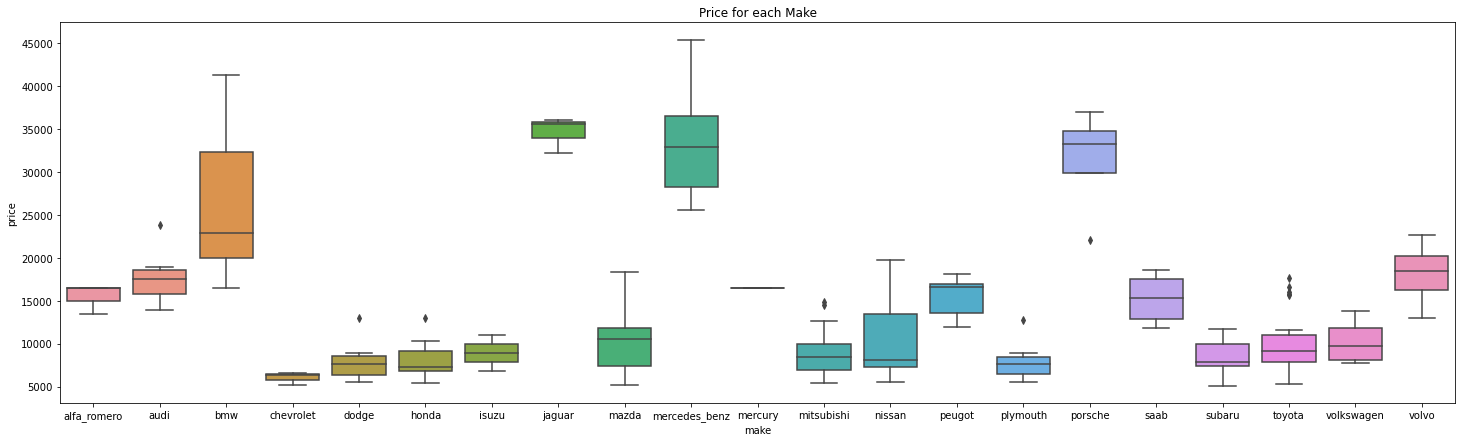

In [77]:
plt.rcParams['figure.figsize']=(25,7)
sn.boxplot(x='make', y="price", data=data_no_OH).set_title('Price for each Make');

#### Horsepower

Todos son valores normales.

Text(0.5, 1.0, 'Global Horsepower')

count    199.000
mean     103.397
std       37.554
min       48.000
25%       70.000
50%       95.000
75%      116.000
max      262.000
Name: horsepower, dtype: float64

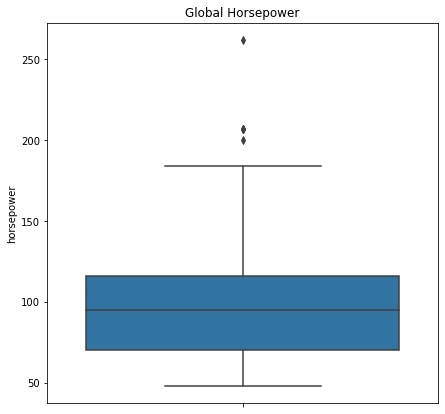

In [78]:
plt.rcParams['figure.figsize']=(7,7)
sn.boxplot(y="horsepower", data=data_no_OH).set_title('Global Horsepower');
data.horsepower.describe()

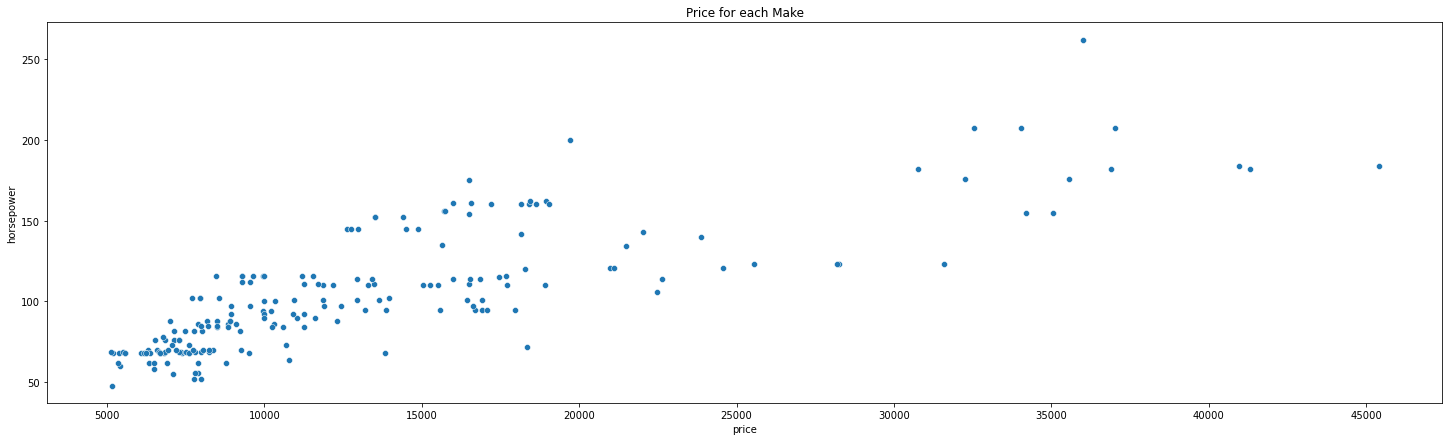

In [79]:
plt.rcParams['figure.figsize']=(25,7)
sn.scatterplot(x='price', y="horsepower", data=data_no_OH).set_title('Price for each Make');

#### Num of doors

El atributo referente al numero de puertas de un vehiculo no parece a priori relevante. Es cierto que los coches deportivos (mas caros) suelen ser de dos puertas, pero a pesar es esto, no parece un atributo muy relevante para decidir el precio de un vehiculo.

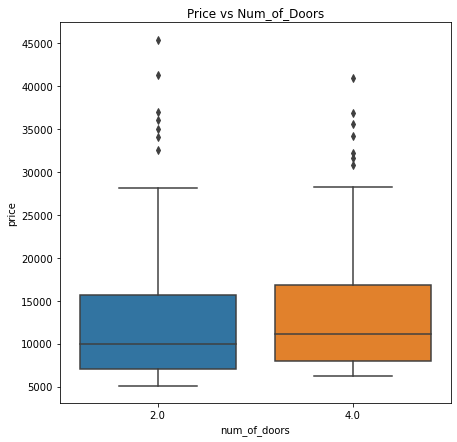

In [80]:
plt.rcParams['figure.figsize']=(7,7)
sn.boxplot(x="num_of_doors", y='price', data=data_no_OH).set_title('Price vs Num_of_Doors');

Por ser poco explicativa, este atributo sera eliminado.

In [81]:
data.drop(columns=['num_of_doors'], inplace=True);
data_no_OH.drop(columns=['num_of_doors'], inplace=True);

#### engine_size (cubicaje)

Nos hemos dado cuenta de esta variable representa el cubicaje de los motores. Este valor en el mundo real afecta mucho al precio del vehiculo, y como podemos ver en la matriz de correlaciones, en este dataset tambien. Este valor es derivado de los atributos stroke,bore y num_of_cylinders, ya que con estos valores podemos estimar el volumen total del motor. Esta relacion se refleja tambien en la correlacion de engine_size con estas variables. Por ello, hemos decidido, con el fin de reducir la dimensionalidad, eliminar estos 3 atributos.

In [82]:
data.drop(columns=['bore'], inplace=True)
data.drop(columns=['stroke'], inplace=True)
data.drop(columns=['num_of_cylinders'], inplace=True)

data_no_OH.drop(columns=['bore'], inplace=True)
data_no_OH.drop(columns=['stroke'], inplace=True)
data_no_OH.drop(columns=['num_of_cylinders'], inplace=True)

#### Wheelbase (Distancia entre ejes)

Podemos ver en el grafico que los datos tienen una muy ligera tendencia de crecimiento con el precio. Decidimos dejarlo y posteriormente, segun lo que los modelos utlicen la variable, decidiremos utilizarla o no.

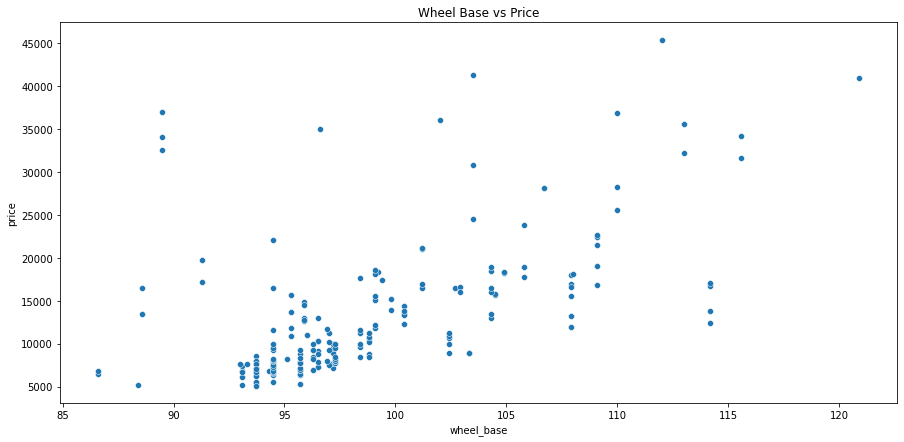

In [83]:
plt.rcParams['figure.figsize']=(15,7)
sn.scatterplot(x="wheel_base", y='price', data=data_no_OH).set_title('Wheel Base vs Price');

#### Tamaño del vehiculo (Lenght, Height, Width)

De las 3, la altura es la menos representativa (la que menos afecta al precio directamente), pero por lo general, y los graficos lo revelan, hay una tendencia de cuanto mas grande el vehiculo, mas caro es.

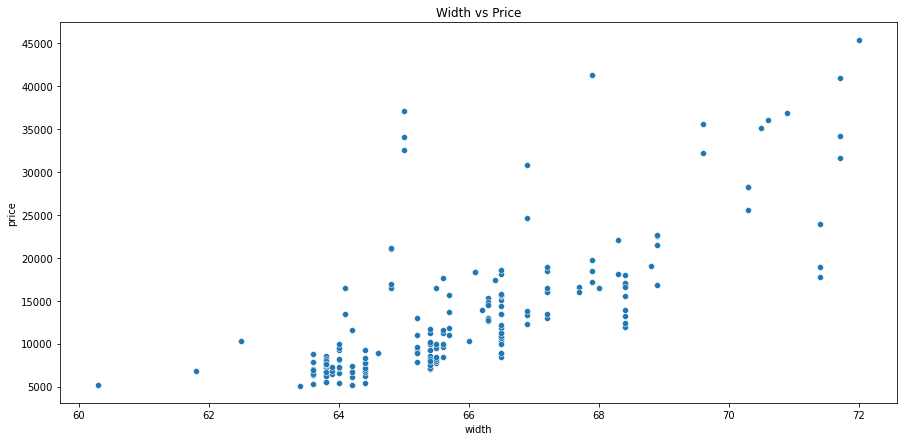

In [84]:
plt.rcParams['figure.figsize']=(15,7)
sn.scatterplot(x="width", y='price', data=data_no_OH).set_title('Width vs Price');

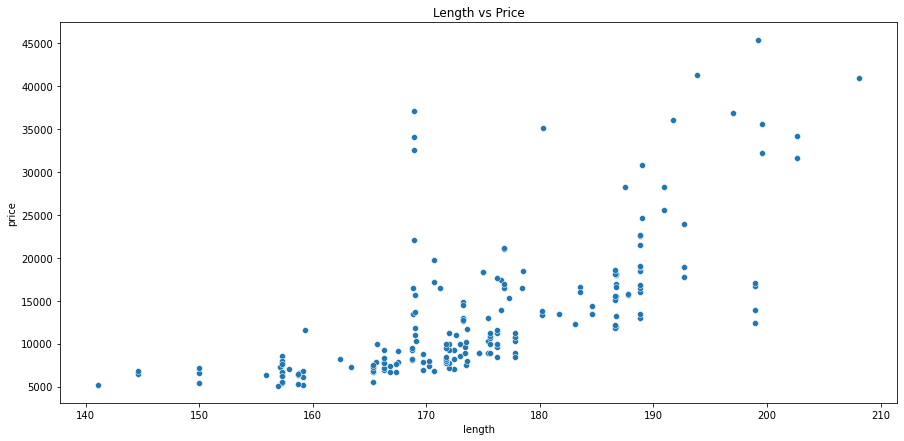

In [28]:
plt.rcParams['figure.figsize']=(15,7)
sn.scatterplot(x="length", y='price', data=data_no_OH).set_title('Length vs Price');

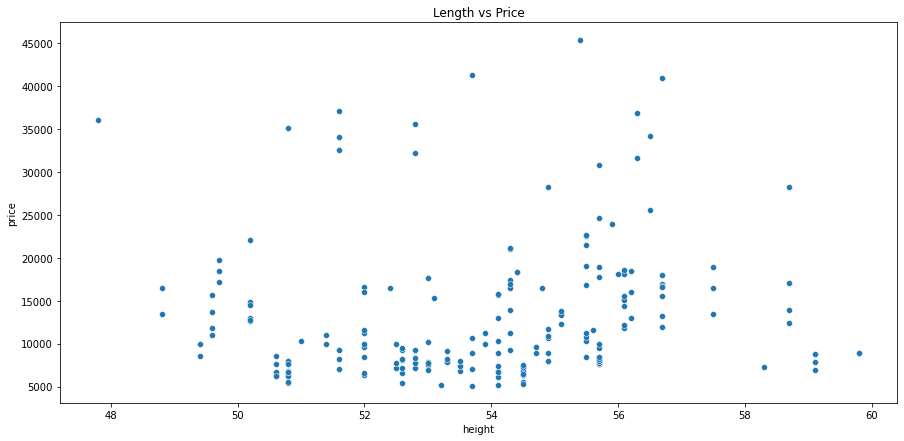

In [29]:
plt.rcParams['figure.figsize']=(15,7)
sn.scatterplot(x="height", y='price', data=data_no_OH).set_title('Length vs Price');

#### Fuel type

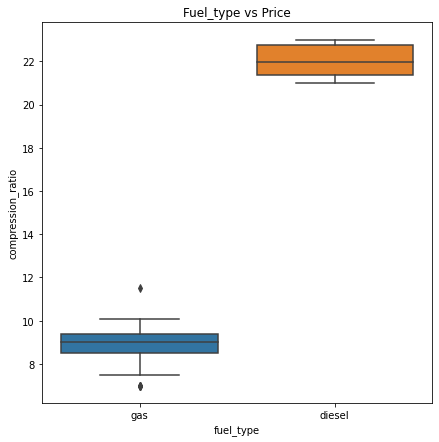

In [30]:
plt.rcParams['figure.figsize']=(7,7)
sn.boxplot(x="fuel_type", y='compression_ratio', data=data_no_OH).set_title('Fuel_type vs Price');

Los motores diesel tienen el doble de ratio de compresión que los de gasolina, por lo tanto podemos suprimir el tipo de combustible ya que estan correlacionadas

In [31]:
data.drop(columns=['fuel_type_diesel'], inplace=True)
data.drop(columns=['fuel_type_gas'], inplace=True)
data_no_OH.drop(columns=['fuel_type'], inplace=True)

#### PeakRPM

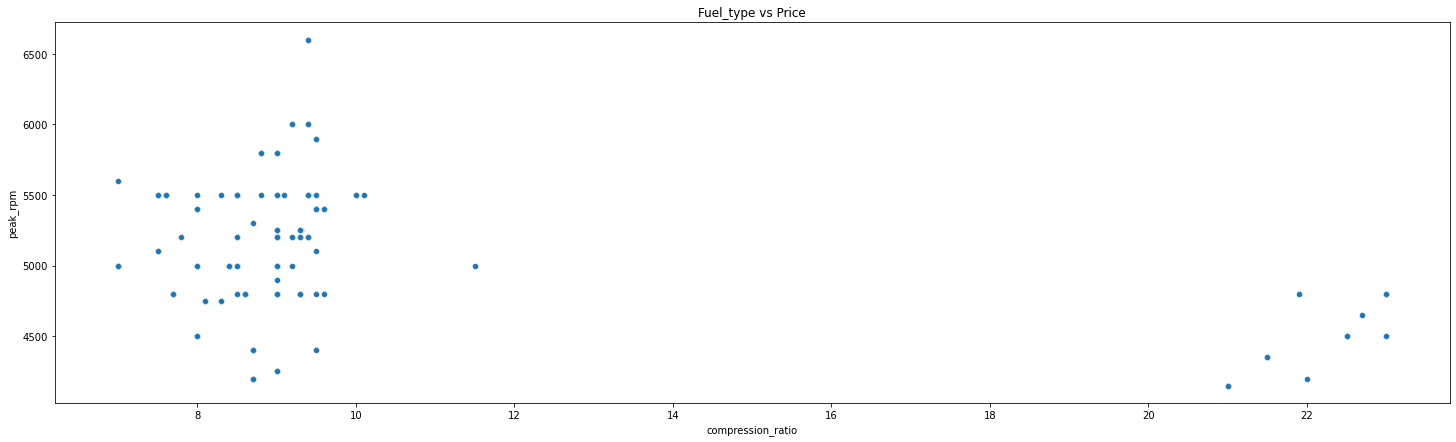

In [32]:
plt.rcParams['figure.figsize']=(25,7)
sn.scatterplot(x="compression_ratio", y='peak_rpm', data=data_no_OH).set_title('Fuel_type vs Price');

Esta variable no nos aporta nada ya que se puede comprobar que para compression ratio no es capaz de distinguir entre diesel y gasolina (los puntos comparten altura en el grafico) y, aunque fuera capaz de hacer lo, solo estariamos añadiendo redundancia a los datos ya que compressión ratio puede distinguir perfectamente entre estas clases.

In [33]:
data.drop(columns=['peak_rpm'], inplace=True)
data_no_OH.drop(columns=['peak_rpm'], inplace=True)

#### curb_weight (Peso en vacio del vehiculo)

El peso se ve principalmente condicionado por el peso del motor, lo cual se deriva directamente de el atributo 'engine_size'. Obviamente esta tambien relacionado con las dimensiones del vehiculo y con el consumo del mismo. Pero a pesar de esto (los cuales serian motivo para plantearse la eliminacion de una variable por redundancia), existe el factor "calidad de construccion de los materiales" lo cual va ligado a un mayor peso y mayor precio (sobretodo en la epoca del dataset, años 80-90).

Por esta razon, mantenemos la variable, por ser altamente explicativa, tanto numericamente como conceptualmente.

#### City-MPG / Highway-MPG (Consumos)

Los consumos estan muy correlaciones entre ellos pero son diferentes. La diferencia entre estos es que el consumo urbano se ve mas afectado por el peso, y el consumo en carretera por la aerodinamica. Al no contar con datos sobre la aerodinamica, como podria ser el CX, creemos adecuado mantener estos consumos en los datos, ya que de estos se puede extraer informacion extra que no tenemos. Ademas estan tambien altamente correlacionados con el precio del vehiculo.

#### Normaliced_losses

Al ser datos normalizados, no podemos compararlos directamente (aparentemente las correlaciones no son muy altas). Por ello creemos conveniente dejar el atributo, y si posteriormente vemos que no es util a los metodos, actuar en consecuencia.

In [34]:
data.normalized_losses.describe()

count    199.000
mean     125.913
std       35.235
min       65.000
25%       99.500
50%      122.000
75%      150.000
max      256.000
Name: normalized_losses, dtype: float64

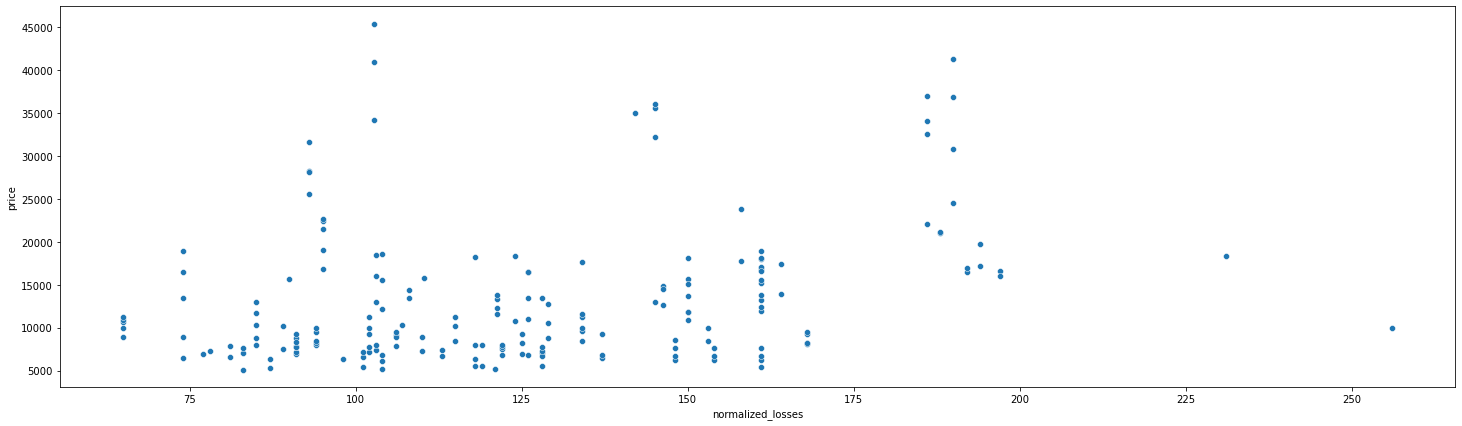

In [35]:
plt.rcParams['figure.figsize']=(25,7)
sn.scatterplot(x="normalized_losses", y="price", data=data_no_OH);

 ### Atributos categoricos

#### Symboling

La variable symboling es aparentemente normal, lo cual tiene sentido dentro del contexto, ya que, lo normal es que las compañias de seguros no pierdan dinero con los vehiculos asegurados y por lo tanto, el riesgo asociado a estos sea neutro. Tambien vemos que se tiende mas a considerar un vehiculo como "de riesgo" que "no de riesgo".

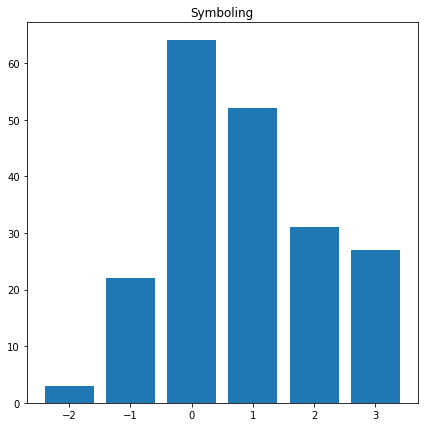

In [36]:
plt.rcParams['figure.figsize']=(7,7);
plt.bar([0, 1, 2, 3, -1, -2], data.symboling.value_counts());
plt.title("Symboling");

#### Aspiration

Es un atributo altamente desbalanceado que no parece separar ni entre gas/diesel, ni entre consumos altos/bajos. Como estamos en la tarea de regresion sobre el precio, el desbalanceo no es tan critico como en clasificacion (donde habria que tener en cuenta los modelos constantes).

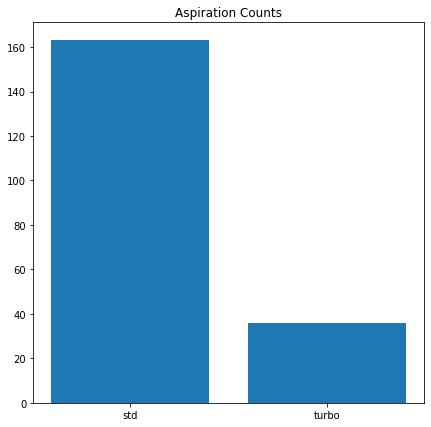

In [37]:
plt.rcParams['figure.figsize']=(7,7);
plt.bar(['std', 'turbo'], data.aspiration_std.value_counts());
plt.title("Aspiration Counts");

#### Make

Anteriormente en el apartado de dummy variables hemos transformado las etiquetas a one hot encoding, estos són los resultados obtenidos, una posible transformación seria convertir las marcas de los vehiculos a continente de procedencia ya que los vehiculos de importación tienden a ser mas caros.

Inicialmente no vamos a convertir estos datos, si vemos que hay problemas con la adición de estas cambiaremos el enfoque.

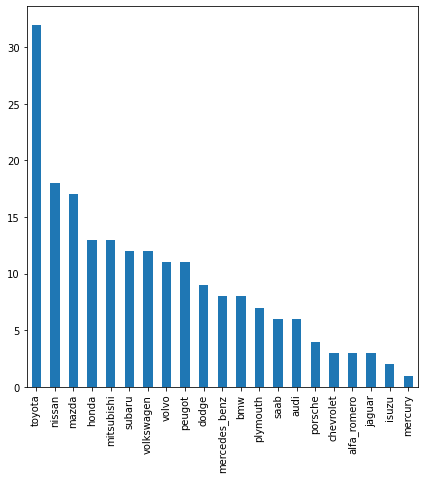

In [38]:
data_no_OH.make.value_counts().plot(kind='bar');

#### Drive_wheels

Si exploramos como es la situación en relación a la tracción de los coches nos encontramos con una situación desbalanceada desde los coches con tracción a cuatro ruedas, en el caso de las tracciones delanteras y traseras estas se distribuyen mejor, en principio vamos a dejar esta métrica para ver como se comporta el modelo.

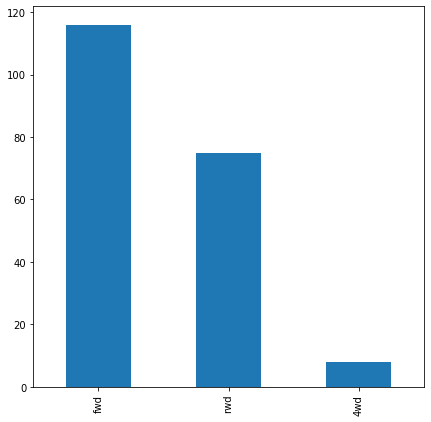

In [39]:
data_no_OH.drive_wheels.value_counts().plot(kind='bar');

#### Body_style

A pesar del desbalanceo entre clases, creemos que puede ser de utilidad al modelo porque las clases mayoritarias tienden a ser mas baratas (algo que pasa en el mundo real) mientras que los modelos mas distintivos como pueden ser los descapotables tienen una tendencia superior al precio. Esto se puede apreciar en los boxplots.

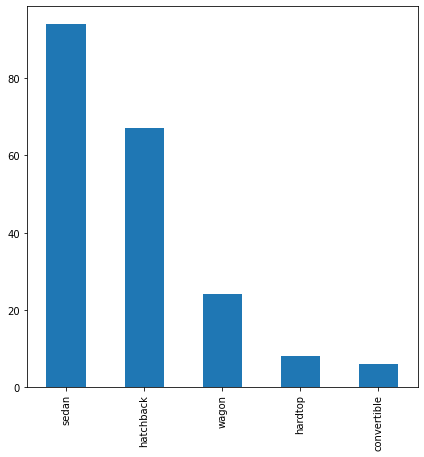

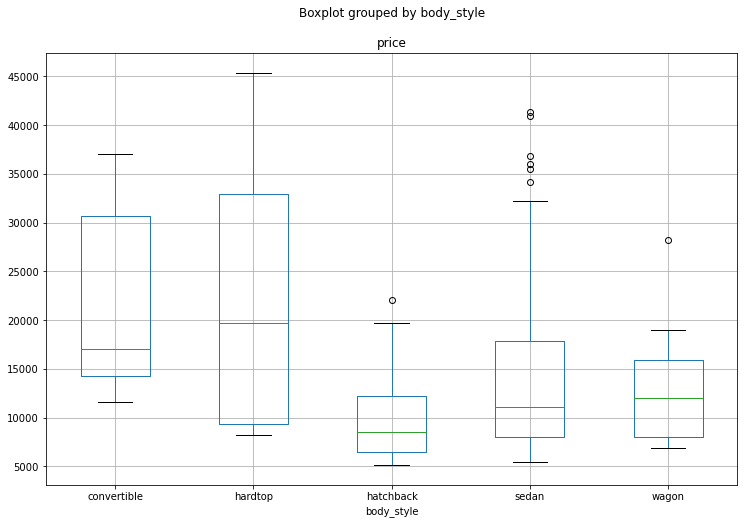

In [40]:
data_no_OH.body_style.value_counts().plot(kind='bar');
data_no_OH.boxplot(column='price', by='body_style', figsize=(12,8));

#### Engine_type

Podemos ver claramente que hay un gran desbalanceo entre clases. El motor de tipo "OHC" es el mayoritario, y el que cuenta con vehiculos en todos los rangos. A pesar de esto, vemos que este tipo de motor, justo y precisamente por ser el mayoritario, por lo general es de los mas economicos. Creemos que puede ser interesante mantenerlo.

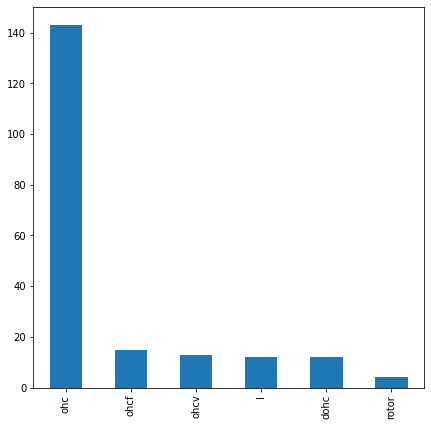

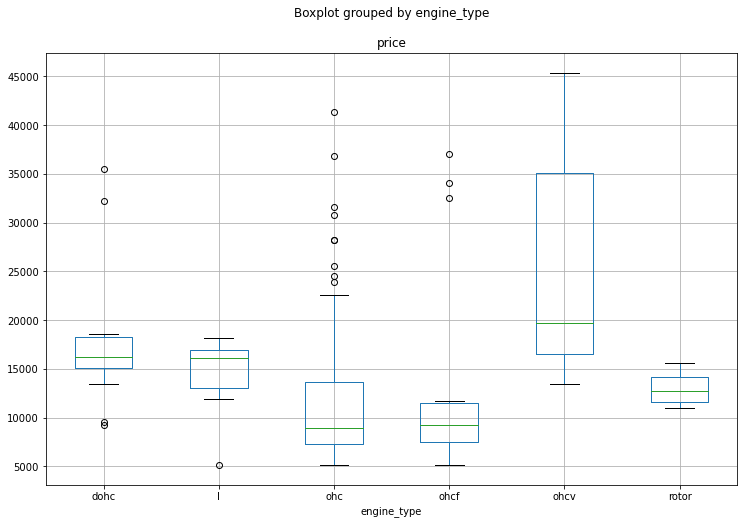

In [41]:
data_no_OH.engine_type.value_counts().plot(kind='bar');
data_no_OH.boxplot(column='price', by='engine_type', figsize=(12,8));

#### Fuel_system

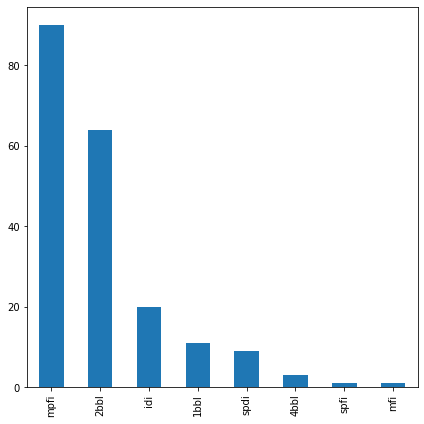

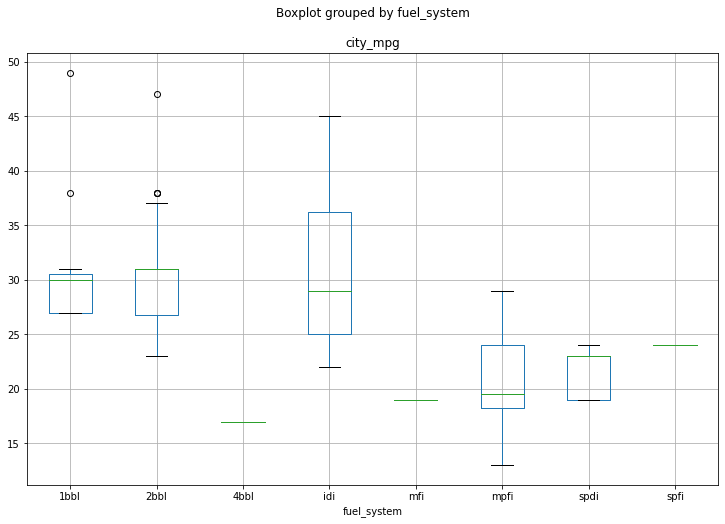

In [42]:
data_no_OH.fuel_system.value_counts().plot(kind='bar');
data_no_OH.boxplot(column='city_mpg', by='fuel_system', figsize=(12,8));

Intentamos reducir la dimensionalidad de los datos, reduciendo el sistema de addicion de combustible a los dos grandes tipos: Inyeccion y Carburacion


Injection:
* IDI
* MFI
* MPFI
* SPFI
* SPDI

Carburator:
* 1BBL
* 2BBL
* 4BBL

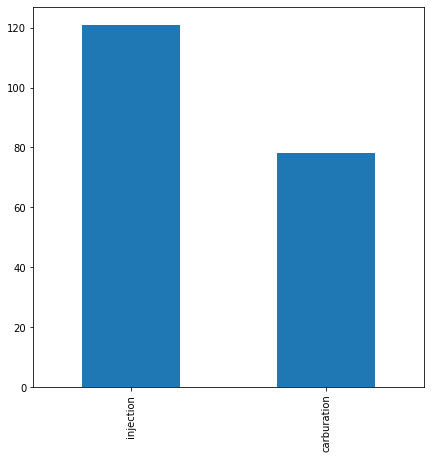

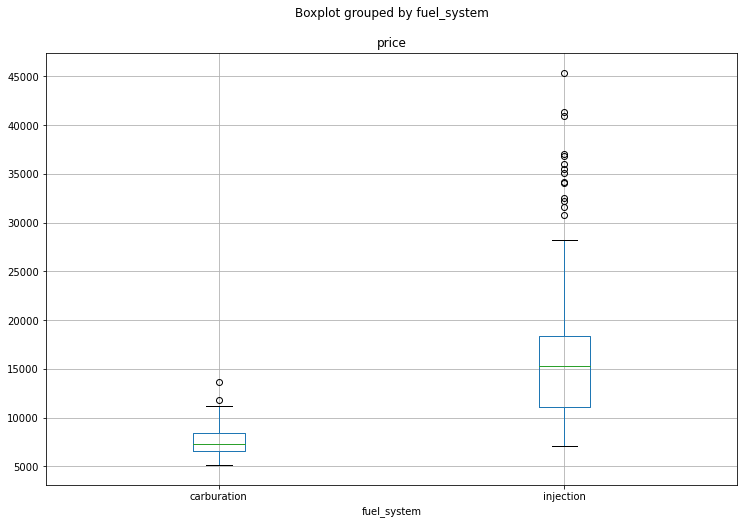

In [43]:
data_aux = data_no_OH.copy()

fuel_system_list = ['idi', 'mpfi', 'spdi', 'mfi', 'spfi', '1bbl', '2bbl', '4bbl']
fuel_system_replace = 5 * ['injection'] + 3 * ['carburation'];
data_aux.fuel_system.replace(fuel_system_list,fuel_system_replace, inplace=True)

data_aux.fuel_system.value_counts().plot(kind='bar');
data_aux.boxplot(column='price', by='fuel_system', figsize=(12,8));

Podemos ver como de esta manera las clases se han balanceado bastante y ahora si que existe una frontera entre precios (sobretodo en entre el 75% de las muestras). Creemos conveniente sustituir el atributo para solo diferenciar entre estas dos clases:

In [44]:
fuel_systems = ['fuel_system_1bbl', 'fuel_system_2bbl', 'fuel_system_4bbl', 
               'fuel_system_idi', 'fuel_system_mfi', 'fuel_system_mpfi',
               'fuel_system_spdi', 'fuel_system_spfi']

# data.drop(columns=fuel_systems, inplace=True)
data['fuel_system'] = data_aux.fuel_system
data_no_OH['fuel_system'] = data_aux.fuel_system
data = pd.get_dummies(data, columns=['fuel_system'], prefix=['fuel_system'])

#### Engine Location

Esta variable podemos ver que esta tan desbalanceada, que practicamente es como si no existiese. Ergo, es totalmente conveniente eliminar un dato en el que el practicamente el total de las muestras pertenece a una clase.

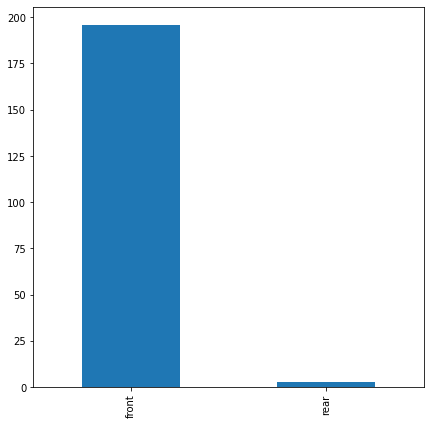

In [45]:
data_no_OH.engine_location.value_counts()
data_no_OH.engine_location.value_counts().plot(kind='bar');

In [46]:
data_no_OH.drop(columns=['engine_location'], inplace=True);
data.drop(columns=['engine_location_front','engine_location_rear'], inplace=True);

## Normalizacion de Variables Numericas

No hay mucha diferencia entre rangos (magnitudes) de los atributos. Los mas grandes son el peso del vehiculo (que esta entre aproximadamente 1500 y 4000) y el precio, pero este es valor que queremos predecir.

In [47]:
data.describe()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,...,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi,fuel_system_carburation,fuel_system_injection
count,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,...,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000
mean,0.839,125.913,98.824,174.151,65.882,53.776,2556.030,126.824,10.179,103.397,...,0.055,0.322,0.015,0.101,0.005,0.452,0.045,0.005,0.392,0.608
std,1.257,35.235,6.091,12.372,2.111,2.447,519.856,41.753,4.022,37.554,...,0.229,0.468,0.122,0.301,0.071,0.499,0.208,0.071,0.489,0.489
min,-2.000,65.000,86.600,141.100,60.300,47.800,1488.000,61.000,7.000,48.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,99.500,94.500,166.550,64.100,52.000,2157.000,97.500,8.550,70.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,122.000,97.000,173.200,65.500,54.100,2414.000,119.000,9.000,95.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,2.000,150.000,102.400,183.500,66.700,55.550,2930.500,143.000,9.400,116.000,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000
max,3.000,256.000,120.900,208.100,72.000,59.800,4066.000,326.000,23.000,262.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Guardamos datos limpios

Mezclamos los datos de forma aleatoria para eliminar posibles sesgos debitos al orden de las tuplas.

In [48]:
np.random.seed(42)
clean_data = data.sample(frac=1).reset_index(drop=True)

Guardamos los datos en un pickle para su posterior uso:

In [49]:
clean_data.to_pickle('dataset/Automobile-processed.pkl.bz2',compression='bz2')

In [86]:
X = clean_data.drop(columns=['price'])
Y = clean_data.price

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

X_train.to_pickle('dataset/Automobile-processed-X_train.pkl.bz2',compression='bz2')
Y_train.to_pickle('dataset/Automobile-processed-Y_train.pkl.bz2',compression='bz2')
X_test.to_pickle('dataset/Automobile-processed-X_test.pkl.bz2',compression='bz2')
Y_test.to_pickle('dataset/Automobile-processed-Y_test.pkl.bz2',compression='bz2')

Probamos a cargar los datos para ver que todo ha ido bien:

In [87]:
clean_data = pd.read_pickle('dataset/Automobile-processed.pkl.bz2',compression='bz2')
clean_data.head()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,...,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi,fuel_system_carburation,fuel_system_injection
0,1,125.0,96.3,172.4,65.4,51.6,2365,122,8.5,88.0,...,0,1,0,0,0,0,0,0,1,0
1,0,190.0,103.5,193.8,67.9,53.7,3380,209,8.0,182.0,...,0,0,0,0,0,1,0,0,0,1
2,0,161.0,114.2,198.9,68.4,58.7,3485,152,21.0,95.0,...,0,0,0,1,0,0,0,0,0,1
3,2,122.0,97.3,171.7,65.5,55.7,2209,109,9.0,85.0,...,0,0,0,0,0,1,0,0,0,1
4,1,161.0,93.0,157.3,63.8,50.8,2145,98,7.6,102.0,...,0,0,0,0,0,0,1,0,0,1
